    Tutorial "Anomaly detection with Autoencoders". The tutorial is based on "Anomalies, Representations, and Self-Supervision" (arXiv:2301.04660). The aim here is to reproduce the upper left panel of Figure 1 of arXiv:2301.04660. Please ensure following necessary modules are isntalled. 

In [1]:
import os           # Importing operating system functionalities.
import sys          # Importing system-specific parameters and functions.
import random       # Importing random number generator functions.
import time         # Importing time-related functions.
import numpy as np  # Importing numerical computing library and aliasing as "np".

import torch                                # Importing PyTorch library for neural networks.
from torch.utils.data import Dataset        # Importing the Dataset class for creating custom datasets.
from torch.utils.data import DataLoader     # Importing DataLoader class for loading data in batches.
from torch import nn                        # Importing neural network module for building network architectures.
from torch.nn import functional as F          # Importing functional module for various loss functions and activations.
from torch.nn import Sequential, Linear, ReLU  # Importing specific neural network layers.
import torch.optim as optim                    # Importing optimization algorithms like SGD, Adam, etc.


#Plotting set up


from matplotlib import pyplot as plt        # Importing the pyplot module from the matplotlib library for creating plots.
import matplotlib                          # Importing the matplotlib library for visualization.
import warnings                            # Importing the warnings module for managing warnings in the code.
warnings.filterwarnings("ignore")           # Filtering out and ignoring warnings in the output.
from matplotlib.lines import Line2D                    # Importing Line2D class for creating custom lines in plots.
from matplotlib.font_manager import FontProperties    # Importing FontProperties class for managing font properties in plots.
import matplotlib.colors as mcolors                   # Importing color-related functions and classes from matplotlib.
import colorsys                                        # Importing colorsys for color transformations (RGB to HSV, etc.).
from sklearn.metrics import roc_curve, roc_auc_score  # Importing functions for ROC curve and AUC score calculations.


In [2]:
# Set up for plots in the following

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True


     Loading of the data file and preprocessing. In the following I prepared for training data files "background20k.npy".   "background50k.npy". If you're targetting less computationally expensive runs use "background20k.npy". There is also a New Physics (NP) signal "signalAto4l.npy", which contains 10k events. The NP signal is essentially a 50 GeV neutral CP odd scalar boson A with pp → A + X → Z^∗ Z^∗ + X (with X is inclusive activity) followed by both Z^∗ decaying into charged leptons.  Both the signal and backgrounds are based on JHEP 05, 036 (2019),doi:10.1007/JHEP05(2019)036, arXiv:1811.10276. A detailed discussion on how the background and NP Samples are generated can be found in JHEP 05, 036 (2019). Both the background and NP events have shape (N,19,3). 
     
     The collider event data being used has a well-defined structure:
     • MET: one entry with (pT , η, φ)
     • Electrons: four entries, each with (pT , η, φ)
     • Muons: four entries, each with (pT , η, φ)
     • Jets: ten entries, each with (pT , η, φ).
     This amounts to a 19 × 3 array, with the electrons, muons, and jets being ordered by pT and having zero-padded entries where there is less than the maximum allowed number of reconstructed objects. The multiplicity is typically much less than the maximum allowed, so the data for a single collider event can have very many zeros.

In [3]:
sig = np.load("/home/tanmoyy/HEP/ml/ictp_tutorial/signalAto4l.npy")
sig[:,:,0] /= np.mean(sig[:,:,0].flatten()[(0 < sig[:,:,0].flatten())])
sig[:,:,1] /= np.max(sig[:,:,1])
sig[:,:,2] /= np.max(sig[:,:,2])
print(sig.shape)


bkg = np.load("/home/tanmoyy/HEP/ml/ictp_tutorial/background50k.npy")
bkg[:,:,0] /= np.mean(bkg[:,:,0].flatten()[(0 < bkg[:,:,0].flatten())])
bkg[:,:,1] /= np.max(bkg[:,:,1])
bkg[:,:,2] /= np.max(bkg[:,:,2])
print(bkg.shape)

(10000, 19, 3)
(50000, 19, 3)


In [4]:
#Flattening the data

sig_full = np.reshape(sig, (sig.shape[0],-1) )
bkg_full = np.reshape(bkg, (bkg.shape[0],-1) )

trn_size = 40_000

# Dividing into training and validation samples
trn_data = bkg_full[:trn_size]
val_data = bkg_full[trn_size:]


# Converting into Torch tensor
trn_data = torch.Tensor( trn_data )
val_data  = torch.Tensor( val_data )
sig_full = torch.Tensor( sig_full )

print(trn_data.shape,val_data.shape,sig_full.shape)

trn_dl = DataLoader( trn_data, batch_size=128, shuffle=True )
val_dl = DataLoader( val_data, batch_size=128, shuffle=True )
signal_dl = DataLoader( sig_full, batch_size=128, shuffle=True )

torch.Size([40000, 57]) torch.Size([10000, 57]) torch.Size([10000, 57])


        The netwrok Autoencoder architecture. The encoder and decoder networks have 5 feed forward layers each with 256, 128, 64, 32,and 16 neurons, connected by a 5-dimensional bottleneck. The activation function between layers is a LeakyReLU with default slope. The decoder is a mirrored version of the encoder. We don’t apply regularization techniques during training. The training is performed using Adam optimiser with learning rate 0.001 for 100 epochs.

In [5]:
# AE network architecture
class Autoencoder(nn.Module):
    def __init__(self, data_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder layers: Transform input data_dim to a lower-dimensional representation        
        self.encoder = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 5),
        )
        
        # Decoder layers: Transform the lower-dimensional representation back to data_dim
        self.decoder = nn.Sequential(
            nn.Linear(5, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, data_dim),
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

# training module


def train_epoch(dataloader, model, loss_fn, optimizer):
    # Get the total size of the dataset
    size = len(dataloader.dataset)
    
    for batch, X in enumerate(dataloader):
        # Pass data through the neural network to get predictions
        pred = model(X)
        
        # Compute the loss between the original input (X) and the predictions (pred)
        loss = loss_fn(X, pred)
        
        # Reset gradients in the optimizer
        optimizer.zero_grad()
        
        # Compute gradients by backpropagating the loss
        loss.backward()
        
        # Update weights using the optimizer based on computed gradients
        optimizer.step()
        
        # Print the training loss every 100 updates
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def val_pass(dataloader, model, loss_fn):
    # Get the total size and number of batches in the dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    vl = 0.0
    
    # Turn off gradient computation since only forward pass is needed
    with torch.no_grad():
        for X in dataloader:
            # Pass data through the model to get predictions
            pred = model(X)
            
            # Accumulate validation loss
            vl += loss_fn(X, pred).item()

    # Calculate average validation loss per batch
    vl /= num_batches
    print(f"avg val loss per batch: {vl:>8f}")
    
    return vl

def trn_pass(dataloader, model, loss_fn):
    # Get the total size and number of batches in the dataset
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tl = 0.0
    
    # Turn off gradient computation since only forward pass is needed
    with torch.no_grad():
        for X in dataloader:
            # Pass data through the model to get predictions
            pred = model(X)
            
            # Accumulate training loss
            tl += loss_fn(X, pred).item()

    # Calculate average training loss per batch
    tl /= num_batches
    print(f"avg trn loss per batch: {tl:>8f}")
    
    return tl


     Training module

In [6]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

epochs = 100

# re-initialise the model and the optimizer
model = Autoencoder(trn_data.shape[1])
optimizer = torch.optim.Adam( model.parameters(), lr=0.001 )

# track train and val losses
trn_losses = []
val_losses = []
loss_fn = nn.MSELoss()



for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( trn_dl, model, loss_fn, optimizer )
    separator()
    trn_loss = trn_pass( trn_dl, model, loss_fn )
    trn_losses.append( trn_loss )
    separator()
    val_loss = val_pass( val_dl, model, loss_fn )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.103419  [    0/40000]
current batch loss: 0.048553  [12800/40000]
current batch loss: 0.040704  [25600/40000]
current batch loss: 0.042397  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.040528
-----------------------------------------------
avg val loss per batch: 0.039913
-----------------------------------------------
|
-----------------------------------------------
Epoch 2
-----------------------------------------------
current batch loss: 0.038059  [    0/40000]
current batch loss: 0.032979  [12800/40000]
current batch loss: 0.034235  [25600/40000]
current batch loss: 0.033751  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.030383
-----------------------------------------------
avg val loss per batch: 0.030178
-----------------------------------------------
|
----------------

avg trn loss per batch: 0.013502
-----------------------------------------------
avg val loss per batch: 0.013984
-----------------------------------------------
|
-----------------------------------------------
Epoch 18
-----------------------------------------------
current batch loss: 0.012870  [    0/40000]
current batch loss: 0.014231  [12800/40000]
current batch loss: 0.013189  [25600/40000]
current batch loss: 0.012745  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.013339
-----------------------------------------------
avg val loss per batch: 0.013746
-----------------------------------------------
|
-----------------------------------------------
Epoch 19
-----------------------------------------------
current batch loss: 0.011934  [    0/40000]
current batch loss: 0.011560  [12800/40000]
current batch loss: 0.013539  [25600/40000]
current batch loss: 0.013562  [38400/40000]
-----------------------------------------------
avg trn loss p

current batch loss: 0.010048  [12800/40000]
current batch loss: 0.013163  [25600/40000]
current batch loss: 0.008665  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.010440
-----------------------------------------------
avg val loss per batch: 0.011338
-----------------------------------------------
|
-----------------------------------------------
Epoch 35
-----------------------------------------------
current batch loss: 0.009465  [    0/40000]
current batch loss: 0.009472  [12800/40000]
current batch loss: 0.010824  [25600/40000]
current batch loss: 0.011249  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.010159
-----------------------------------------------
avg val loss per batch: 0.011025
-----------------------------------------------
|
-----------------------------------------------
Epoch 36
-----------------------------------------------
current batch loss: 0.011673  [    0/40000]
current batch 

current batch loss: 0.005548  [12800/40000]
current batch loss: 0.009503  [25600/40000]
current batch loss: 0.008300  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.008370
-----------------------------------------------
avg val loss per batch: 0.009362
-----------------------------------------------
|
-----------------------------------------------
Epoch 52
-----------------------------------------------
current batch loss: 0.007693  [    0/40000]
current batch loss: 0.007696  [12800/40000]
current batch loss: 0.006794  [25600/40000]
current batch loss: 0.009064  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.008314
-----------------------------------------------
avg val loss per batch: 0.009302
-----------------------------------------------
|
-----------------------------------------------
Epoch 53
-----------------------------------------------
current batch loss: 0.008508  [    0/40000]
current batch 

current batch loss: 0.006393  [12800/40000]
current batch loss: 0.009149  [25600/40000]
current batch loss: 0.010498  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.007983
-----------------------------------------------
avg val loss per batch: 0.009069
-----------------------------------------------
|
-----------------------------------------------
Epoch 69
-----------------------------------------------
current batch loss: 0.008374  [    0/40000]
current batch loss: 0.008114  [12800/40000]
current batch loss: 0.009270  [25600/40000]
current batch loss: 0.008898  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.007741
-----------------------------------------------
avg val loss per batch: 0.008895
-----------------------------------------------
|
-----------------------------------------------
Epoch 70
-----------------------------------------------
current batch loss: 0.007778  [    0/40000]
current batch 

current batch loss: 0.007657  [12800/40000]
current batch loss: 0.008266  [25600/40000]
current batch loss: 0.008805  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.007345
-----------------------------------------------
avg val loss per batch: 0.008696
-----------------------------------------------
|
-----------------------------------------------
Epoch 86
-----------------------------------------------
current batch loss: 0.009184  [    0/40000]
current batch loss: 0.008634  [12800/40000]
current batch loss: 0.007903  [25600/40000]
current batch loss: 0.008330  [38400/40000]
-----------------------------------------------
avg trn loss per batch: 0.007494
-----------------------------------------------
avg val loss per batch: 0.008829
-----------------------------------------------
|
-----------------------------------------------
Epoch 87
-----------------------------------------------
current batch loss: 0.008356  [    0/40000]
current batch 

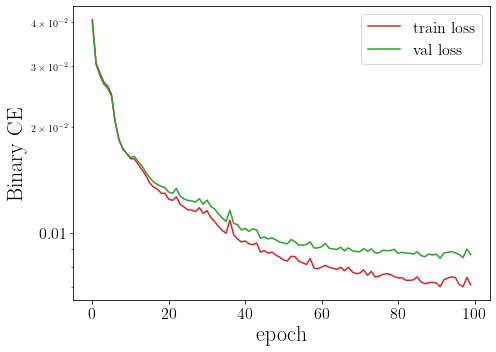

In [7]:
# Plotting the traning and validation loss

fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

axs.set_yscale('log')

axs.set_xlabel( "epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Binary CE", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

Evaluation

In [8]:
#model.eval() #Since the network only consists of Linear and LeakyReLU. So in this case, we don't need model.eval().

In [9]:
samp_size = 10000
#samp_size = 4000   # Switch on if you are using 20k file.
sig_pred = model(sig_full[:samp_size]).detach()
bkg_pred = model(val_data[:samp_size]).detach()

# Create a Mean Squared Error (MSE) loss function with individual loss values not reduced to a scalar
test_loss = nn.MSELoss(reduce=False)

# Calculate the MSE between the predicted signal and the actual signal for each sample
sig_mse = test_loss(sig_pred[:samp_size], sig_full[:samp_size])

# Calculate the MSE between the predicted background and the actual background for each sample
bkg_mse = test_loss(bkg_pred[:samp_size], val_data[:samp_size])

# Calculate the mean MSE value for signal samples along the specified dimension
signal_mse = torch.mean(sig_mse, dim=-1)

# Calculate the mean MSE value for background samples along the specified dimension
background_mse = torch.mean(bkg_mse, dim=-1)

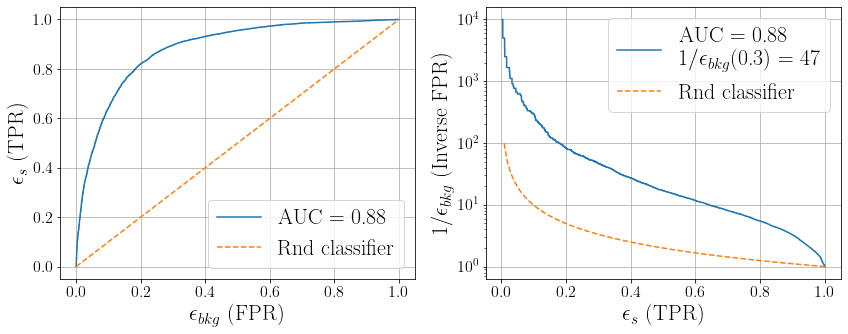

In [10]:
# Generating an array of 100 values linearly spaced between 0 and 1
rnd_cl = np.linspace(0, 1, 100)

# Creating a ground truth array by concatenating arrays of ones (signal) and zeros (background)
truth = np.concatenate((np.ones(signal_mse.shape[0]), np.zeros(background_mse.shape[0])))

# Concatenating signal and background predictions to create a prediction array
prediction = np.concatenate((signal_mse, background_mse))

# Calculating the Receiver Operating Characteristic (ROC) curve
# fpr: False Positive Rate, tpr: True Positive Rate, th: Thresholds
fpr, tpr, th = roc_curve(truth, prediction)

# Calculating the Area Under the ROC Curve (AUC)
auc = roc_auc_score(truth, prediction)

# Function to find the index of the closest point in an array to a given value (default tpr_p=0.3)
def closest_point(array, tpr_p=0.3):
    dist = ((array - tpr_p) ** 2)
    return np.argmin(dist)

# Creating a figure with two subplots (1 row, 2 columns) of size 14x5 inches
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the ROC curve on the first subplot
ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
ax[0].plot(rnd_cl, rnd_cl, '--', label='Rnd classifier')

# Plotting the ROC curve on the second subplot
ax[1].plot(tpr, 1 / fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc, 1 / fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_cl, 1 / rnd_cl, '--', label='Rnd classifier')

# Setting y-axis scale to logarithmic on the second subplot
ax[1].set_yscale('log')

# Setting labels for the x and y axes of the first subplot
ax[0].set_xlabel('$\epsilon_{bkg}$ (FPR)', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ (TPR)', fontproperties=axislabelfont)

# Setting labels for the x and y axes of the second subplot
ax[1].set_xlabel('$\epsilon_{s}$ (TPR)', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ (Inverse FPR)', fontproperties=axislabelfont)

# Adding legends, adjusting font size, enabling grid for both subplots
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')


